In [1]:
import numpy as np
import pandas as pd

import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn import preprocessing

from trace_process import *

TIME_DELTA = 5000 * NANO_TO_MICRO
BATCH_SIZE = 32
MTU = 1514
WINDOW_SIZE = 10

file_name = "../data/13/node-2/train/packets"

In [2]:
df = pd.read_csv(
    file_name, 
    sep='\t', 
    lineterminator='\n', 
    header=None,
    index_col=False,
    names=['timestamp', 'size', 'src', 'dest', 'dir'], 
    dtype={'src': "category", 'dest': "category"},
    on_bad_lines='skip',
    keep_default_na=False,
).dropna()
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df = df[df['dir'] == 1][["timestamp", "size"]]
df = df.sort_values(by='timestamp')

/tmp/ipykernel_115072/334754765.py:1: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [3]:
trace = df.values
flow_packets, flow_times, flow_sizes, flows_span = get_flow_trace_time(trace, TIME_DELTA)
EM = np.median(flow_sizes)
print("Number of flows: ", len(flow_sizes))
print("EM: ", EM)

/home/morteza/code/digger/morteza/trace_process.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flows_packets = np.array([value_trace[slice(*f)] for f in flows])
/home/morteza/code/digger/morteza/trace_process.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flow_times = np.array([time_stamp[slice(*f)] for f in flows])


Number of flows:  56758
EM:  214356.0


In [4]:
np.sum((flow_sizes > EM) * 1) / len(flow_sizes)

0.5

In [5]:
# Reading mem file

#mem_df = pd.read_csv(
#    "../data/3/node-1/train/allocations", 
#    sep='\t', 
#    lineterminator='\n', 
#    header=None,
#    index_col=False,
#    names=['timestamp', 'size'], 
#    dtype={"size": "float64"}
#)
#
#mem_trace = mem_df.values
#
#tmp_mem = mem_trace[:, 1].reshape(-1, 1)
#tmp_mem = preprocessing.MinMaxScaler().fit_transform(tmp_mem)
#mem_trace[:, 1] = tmp_mem.reshape(-1)

# Aligning Mem and Flows

#starts = np.searchsorted(mem_trace[:, 0], flows_span[:, 0])
#ends = np.searchsorted(mem_trace[:, 0], flows_span[:, 1])
#flows_mem_idx = np.column_stack((starts, ends))
#flows_mem_trace = np.array([mem_trace[:, 1][slice(*f)] for f in flows_mem_idx])

In [6]:
TRAIN_SIZE = 20_000
TEST_SIZE = 5_000

indexes = list(range(5, len(flow_sizes) - 1))
random.shuffle(indexes)
train_indexes = indexes[:TRAIN_SIZE]
test_indexes = indexes[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]


In [7]:
def session_2d_histogram(ts, sizes, path, plot=False):
    if len(ts) == 1:
        ts_norm = np.array([0.0])
    else:
        ts_norm = ((np.array(ts) - ts[0]) / (ts[-1] - ts[0])) * MTU
    H, xedges, yedges = np.histogram2d(sizes, ts_norm, bins=(range(0, MTU + 1, 1), range(0, MTU + 1, 1)))

    if plot:
        plt.set_cmap('plasma')
        plt.pcolormesh(xedges, yedges, H)
        plt.xlim(0, MTU + 1)
        plt.ylim(0, MTU + 1)
        plt.xticks([])
        plt.yticks([])
        plt.savefig(path)
    return H

In [8]:
EM = np.median(flow_sizes)

In [9]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.functional import F

from tqdm.notebook import tqdm

import multiprocessing
from concurrent.futures import ProcessPoolExecutor

import random

NUM_PROCESS = 10

In [10]:
class TraceDataset(torch.utils.data.Dataset):
    def __init__(self, flow_times, flow_packets, flow_sizes, indexes, em):
        self.flow_times = flow_times
        self.flow_packets = flow_packets
        self.flow_sizes = flow_sizes
        self.indexes = indexes
        self.em = em
    
    def __getitem__(self, index):
        idx = self.indexes[index]
        y = 1 if self.flow_sizes[idx + 1] > self.em else 0
        x = torch.Tensor(np.array([session_2d_histogram(self.flow_times[idx - i], self.flow_packets[idx - i], '', False) for i in range(WINDOW_SIZE)]))
        return x, y
    
    def __len__(self):
        return len(self.indexes)

In [11]:
train_dataset = TraceDataset(flow_times, flow_packets, flow_sizes, train_indexes, EM)
test_dataset = TraceDataset(flow_times, flow_packets, flow_sizes, test_indexes, EM)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=5)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [13]:
class CNNModel(nn.Module):
    def __init__(self, filters=(10, 20)):
        super().__init__()
        self.filters = filters

        self.conv1 = nn.Conv2d(WINDOW_SIZE, out_channels=self.filters[0], kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(filters[0])
        self.conv2 = nn.Conv2d(filters[0], out_channels=filters[1], kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(filters[1])
        self.d2 = nn.Dropout(p=0.25)
        self.linear1 = nn.Linear(filters[1] * 93 * 93, 64)
        self.d3 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn2(x)

        x = self.d2(x)

        x = x.view(-1, self.filters[-1] * 93 * 93)

        x = self.linear1(x)
        x = F.relu(x)

        x = self.d3(x)

        x = self.linear2(x)

        x = F.sigmoid(x)

        return x

In [14]:
N_EPOCHS = 10

criterion = nn.BCELoss()
model = CNNModel()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum=0.5)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


def get_loss_and_correct(model, batch, criterion, device):
    img, target = batch
    img, target = img.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
    output = model(img)
    output = torch.squeeze(output)

    loss = criterion(output, target)

    pred = torch.round(output).int()
    true_num = pred.eq(target.int().data.view_as(pred)).sum()

    return loss, true_num

def step(loss, optimizer):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


train_losses = []
train_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
  total_train_loss = 0.0
  total_train_correct = 0.0

  model.train()

  for batch in tqdm(train_dataloader, leave=False):
    loss, correct = get_loss_and_correct(model, batch, criterion, device)
    step(loss, optimizer)
    total_train_loss += loss.item()
    total_train_correct += correct.item()

  mean_train_loss = total_train_loss / len(train_dataset)
  train_accuracy = total_train_correct / len(train_dataset)

  train_losses.append(mean_train_loss)

  train_accuracies.append(train_accuracy)

  pbar.set_postfix({'train_loss': mean_train_loss, 'train_accuracy': train_accuracy})
  print(train_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

/home/morteza/anaconda3/envs/torch-test/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.66045


  0%|          | 0/625 [00:00<?, ?it/s]

0.7054


  0%|          | 0/625 [00:00<?, ?it/s]

0.71355


  0%|          | 0/625 [00:00<?, ?it/s]

: 

: 

: 

In [ ]:
torch.save(model.state_dict(), "model.pt")

cpu = torch.device('cpu')
cpu_model = CNNModel()
cpu_model.load_state_dict(torch.load("model.pt", map_location=cpu))


<All keys matched successfully>

In [ ]:
total = 0
correct = 0

for batch in tqdm(test_dataloader, leave=False):
    model.eval()
    with torch.no_grad():
        img, target = batch
        img, target = img.float(), target.float()
        # data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
        output = cpu_model(img)
        output = torch.squeeze(output)
        pred = torch.round(output).int()
        true_num = pred.eq(target.data.view_as(pred)).sum()
        correct += true_num
        total += len(img)
    
print("Test Accuracy: ", correct / total)

  0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy:  tensor(0.6672)


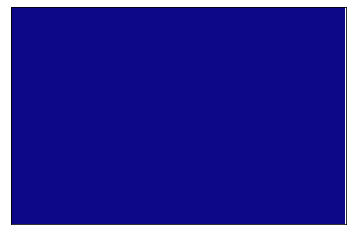

In [ ]:
for idx in train_indexes[:20]:
    c = 'E' if flow_sizes[idx + 1] > EM else 'M'
    session_2d_histogram(flow_times[idx], flow_packets[idx], f'./flowpics/{c}/{idx}', True)